In [2]:
## GRU 입출력  확인
import torch
import torch.nn as nn

# dummy data
input_data = torch.randn((20, 2, 10))
# (20: seq len, 2: batch, 10: 개별 timestep의 입력 feature수)

In [3]:
# 단방향, layer 수: 1
gru1 = nn.GRU(
    input_size=10,      # 개별 timestep의 feature수(embedding_dim)
    hidden_size=256,    # 각 timestep 별로 256개의 특성을 추출.(unit수)
    num_layers=1,       # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=False # 양방향 여부 (default: False)
)
out1, hidden1 = gru1(input_data)
#모든 timestep의 hidden state값을 묶어서 반환.[20:seq len, 2:batch, 256:hidden_size]
print(out1.shape)
# 마지막 timestep 처리 hidden state값 [1: seq len, 2, 256]
print(hidden1.shape)

torch.Size([20, 2, 256])
torch.Size([1, 2, 256])


In [4]:
# bidirectional=True (양방향), layer 수 1개
gru2 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=1, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=True # 양방향 여부 (default: False)
)
out2, hidden2 = gru2(input_data)

# [20:seq_len, 2: batch, 512:hidden_size * 2]   양방향 hidden state를 합쳐서(concat) 반환.
print(out2.shape)
# [2:정/역방향 두개, 2: batch, 256:hidden size]
print(hidden2.shape)

torch.Size([20, 2, 512])
torch.Size([2, 2, 256])


In [5]:
# 단방향, multi layer(4개 층)
gru3 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=4, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=False # 양방향 여부 (default: False)
)
out3, hidden3 = gru3(input_data)

#[20, 2, 256] - 마지막 GRU Layer가 출력한 결과들이 최종 feature이므로 그것을 모아서 반환.
# num_layers가 몇개든 out의 shape은 동일.
print(out3.shape)
# [4: 레이어수, 2, 256]  - 각 layer의 마지막 hidden state들을 모아서 반환
print(hidden3.shape)

torch.Size([20, 2, 256])
torch.Size([4, 2, 256])


In [6]:
# multi layer(4개 층), 양방향

gru4 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=4, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=True # 양방향 여부 (default: False)
)
out4, hidden4 = gru4(input_data)
print(out4.shape) # [20, 2, 512: 양방향 hidden 합친것]
# [8:양방향(2) x 레이어수: 각각, 2, 256]
print(hidden4.shape)

torch.Size([20, 2, 512])
torch.Size([8, 2, 256])


## 데이터 확인

In [7]:
# requests 모듈로 받기
import requests
import os

os.makedirs("data", exist_ok=True)

In [8]:
url = "https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv"
res = requests.get(url)
if res.status_code == 200:
    with open("data/chatbot_data.csv", "wt", encoding="utf-8") as fw:
        fw.write(res.text)
else:
    print(f"불러오지 못함: {url}")

In [9]:
import pandas as pd
df = pd.read_csv('data/chatbot_data.csv')
df.shape

(11823, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [11]:
# 라벨 제거
df.drop(columns='label', inplace=True)

In [12]:
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [13]:
df.tail()

,Q,A
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


# Dataset, DataLoader 정의

## Tokenization

### Subword방식

In [14]:
# token 학습 -> vocab 사전 생성.
## 질문들 + 답변들 합쳐서 학습.
question_texts = df['Q']
answer_texts = df['A']
all_texts = list(question_texts + " "+answer_texts) # 같은 index끼리 합치기 => list로 변환
len(question_texts), len(answer_texts), len(all_texts)

(11823, 11823, 11823)

In [15]:
all_texts[:5]

['12시 땡! 하루가 또 가네요.',
 '1지망 학교 떨어졌어 위로해 드립니다.',
 '3박4일 놀러가고 싶다 여행은 언제나 좋죠.',
 '3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠.',
 'PPL 심하네 눈살이 찌푸려지죠.']

In [16]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

In [17]:
vocab_size = 10_000
min_frequency = 5

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    continuing_subword_prefix='##', # 연결 subword 앞에 붙일 접두어지정.
    special_tokens=["[PAD]", "[UNK]", "[SOS]"] # [SOS]: 문장의 시작을 의미하는 토큰.
)
# tokenizer: token + ##izer
## 학습
tokenizer.train_from_iterator(all_texts, trainer=trainer) # 리스트로 부터 학습
## tokenizer.train("파일경로") # 파일에 있는 text를 학습.

In [18]:
print("총 어휘수:", tokenizer.get_vocab_size())

총 어휘수: 7040


In [19]:
# 토큰화
encode = tokenizer.encode("오늘 날씨가 너무 좋습니다. 즐거운 하루 되세요. 쿄쿄쿜ㅋ")
print(encode.ids)
print(encode.tokens)

[2290, 3852, 2258, 5913, 8, 3271, 2447, 322, 2243, 8, 1, 1, 1, 1920]
['오늘', '날씨가', '너무', '좋습니다', '.', '즐거운', '하루', '되', '##세요', '.', '[UNK]', '[UNK]', '[UNK]', '##ㅋ']


### Tokenizer 저장

In [20]:
dir_path = "saved_model/vocab"
os.makedirs(dir_path, exist_ok=True)
vocab_path = os.path.join(dir_path, "chatbot_bpe.json")
tokenizer.save(vocab_path)

In [21]:
# question_texts, answer_texts

## Dataset, DataLoader 정의


In [22]:
import random
import os
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
class ChatbotDataset(Dataset):
    """
    ChatbotDataset
    parameter:
        question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
        answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
        max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
        tokenizer: Tokenizer
        vocab_size: int 총단어수
    """

    def __init__(self, question_texts, answer_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(q) for q in question_texts]
        self.answer_texts = [self.__process_sequence(a) for a in answer_texts]

    def __pad_token_sequence(self, token_sequence):
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.

        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence) # 입력 문장의 토큰수
        if seq_len > self.max_length: # 문장 최대 토큰수 보다 길다면.
            return token_sequence[:self.max_length]
        else:
            return token_sequence + ([pad_token] * (self.max_length - seq_len))

    def __process_sequence(self, text):
        """
        한 문장(str)을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        # encoding
        encode = self.tokenizer.encode(text) # "........" => [. , . , .]
        # max_length 크기에 맞춘다.
        token_ids = self.__pad_token_sequence(encode.ids) #[3400, 20, 6, 0, 0, 0 ..]
        return token_ids

    def __len__(self):
        return len(self.question_texts)


    def __getitem__(self, index):
        # return  index의 (질문토큰들,  답변토큰들)
        q = self.question_texts[index]  # List
        a = self.answer_texts[index]
        # List->LongTensor. nn.Embedding()의 입력(정수타입)으로 들어간다.
        return torch.tensor(q, dtype=torch.int64), torch.tensor(a, dtype=torch.int64)


In [24]:
# 적당한 max_length 값: 전체 문장 총 토큰수의 9분위수
import numpy as np
a = [len(tokenizer.encode(s).ids) for s in all_texts]
# a[:5]
np.quantile(a, q=[0.9, 0.95, 1.0])
# max_length=20

array([17., 19., 41.])

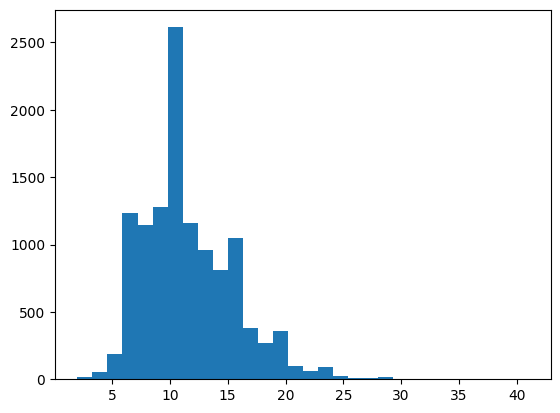

In [25]:
import matplotlib.pyplot as plt
plt.hist(a, 30);

In [26]:
############# Dataset 셍상
MAX_LENGTH = 20
dataset = ChatbotDataset(question_texts, answer_texts, MAX_LENGTH, tokenizer)
len(dataset)

11823

In [27]:
dataset[0]

(tensor([  10, 1662, 1383,  368,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([6118,  378,   47, 2252,    8,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]))

### Trainset / Testset 나누기
train : test = 9 : 1

In [28]:
int(len(dataset) * 0.9)

10640

In [29]:
train_size = int(len(dataset)*0.9)
test_size = len(dataset) - train_size
print(train_size, test_size)

10640 1183


In [30]:
# random_split()이용해서 분리
###shuffle 후 개수에 맞게 나눔
train_set, test_set = random_split(dataset, [train_size, test_size])

In [31]:
type(dataset), type(train_set)

(__main__.ChatbotDataset, torch.utils.data.dataset.Subset)

### DataLoader 생성

In [32]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [33]:
len(train_loader), len(test_loader) # step 수

(166, 19)

# 모델 정의



## Encoder


In [34]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim,
                 hidden_size, bidirectional=True, num_layers=1, dropout_rate=0.0):
        super().__init__()
        # Encoder는 context vector(문장의 feature)를 생성하는 것이 목적 (분류기는 생성안함.)
        # Embedding Layer, GRU Layer를 생성.
        self.vocab_size = vocab_size # 어휘사전의 총 어휘수(토큰수)
        # 임베딩레이어
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,   # embedding vector shape: [vocab_size, embedding_dim]
            padding_idx=0
        )
        # GRU
        self.gru = nn.GRU(
            embedding_dim, # 개별 토큰(time step)의 크기.
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate
        )

    def forward(self, X):
        X = self.embedding(X) # (batch, seq_len, embedding_dim)
        X = X.transpose(1, 0) # (seq_len, batch, embedding_dim)
        out, hidden = self.gru(X)
        return out, hidden

In [36]:
from torchinfo import summary
encoder_model = Encoder(1000, 200, 256)
dummy_data = torch.zeros((64, 20), dtype=torch.int64)  #(batch:64, seq_len:20)
summary(encoder_model, input_data=dummy_data)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [20, 64, 512]             --
├─Embedding: 1-1                         [64, 20, 200]             200,000
├─GRU: 1-2                               [20, 64, 512]             703,488
Total params: 903,488
Trainable params: 903,488
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 913.26
Input size (MB): 0.01
Forward/backward pass size (MB): 7.29
Params size (MB): 3.61
Estimated Total Size (MB): 10.92

## Decoder

In [37]:
class Decoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim,
                 hidden_size, num_layers=1, bidirectional=False, dropout_rate=0.0):
        super().__init__()
        self.vocab_size = vocab_size # 총 어휘사전 토큰 개수.
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # GRU
        ## Auto Regressive RNN은 단방향만 가능.
        self.gru = nn.GRU(embedding_dim, hidden_size,
                          num_layers=num_layers, dropout=dropout_rate)
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        # 분류기 (다음 단어(토큰)를 추론)
           # - 다중분류(단어사전의 단어들의 다음 단어일 확를)
        self.lr = nn.Linear(
            hidden_size,  # GRU 출력 값 중 마지막 hidden state값을 입력으로 받음.
            vocab_size    # 출력: 다음 단어일 확률.
        )

    def forward(self, X, hidden):
        # X: torch.LongTensor: shape - [batch] : 한 단어씩 입력을 받음.
        # hidden: torch.FloatTensor: shape - [1, batch, hidden_size] (이전까지의 특성)

        X = X.unsqueeze(1) # seq_len 축을 추가. [batch] -> [batch, 1] (Embedding Layer의 input shape)
        X = self.embedding(X) # [batch, 1, embedding 차원]
        X = X.transpose(1, 0) # [1, batch, embedding 차원]

        out, hidden = self.gru(X, hidden)
        last_out = out[-1] # out: 전체 hidden state값-> 마지막 hidden state을 추출
        last_out = self.lr(last_out)

        return last_out, hidden # (hidden: 다음 timestep에 전달.)

In [38]:
#### summary

decoder_model = Decoder(1000, 200, 256)

dummy_input = torch.ones((64, ), dtype=torch.int64)
dummy_hidden = torch.ones((1, 64, 256), dtype=torch.float32)

summary(decoder_model, input_data=(dummy_input, dummy_hidden))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 1000]                --
├─Embedding: 1-1                         [64, 1, 200]              200,000
├─GRU: 1-2                               [1, 64, 256]              351,744
├─Linear: 1-3                            [64, 1000]                257,000
Total params: 808,744
Trainable params: 808,744
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.76
Input size (MB): 0.07
Forward/backward pass size (MB): 0.75
Params size (MB): 3.23
Estimated Total Size (MB): 4.05

## Seq2Seq 모델

- Encoder - Decoder 를 Layer로 가지며 Encoder로 질문의 feature를 추출하고 Decoder로 답변을 생성한다.

### Teacher Forcing
- **Teacher forcing** 기법은, RNN계열 모델이 다음 단어를 예측할 때, 이전 timestep에서 예측된 단어를 입력으로 사용하는 대신 **실제 정답 단어(ground truth) 단어를** 입력으로 사용하는 방법이다.
    - 모델은 이전 시점의 출력 단어를 다음 시점의 입력으로 사용한다. 그러나 모델이 학습할 때 초반에는 정답과 많이 다른 단어가 생성되어 엉뚱한 입력이 들어가 학습이 빠르게 되지 않는 문제가 있다.
> - RNN 기반 모델은 시퀀스를 한 단계씩 예측한다.
> - 이때 각 단계의 입력은 이전 단계의 출력인데, 이 출력값이 틀릴 경우 오류가 누적된다.
> - 그래서 학습 중에는 "정답을 정답으로 줘서" 모델이 빠르게 수렴하게끔 도와주는 것.

- **장점**
    - **수렴 속도 증가**: 정답 단어를 사용하기 때문에 모델이 더 빨리 학습할 수있다.
    - **안정적인 학습**: 초기 학습 단계에서 모델의 예측이 불안정할 때, 잘못된 예측으로 인한 오류가 다음 단계로 전파되는 것을 막아줍니다.
- **단점**
    - **노출 편향(Exposure Bias) 문제:** 실제 예측 시에는 정답을 제공할 수 없으므로 모델은 전단계의 출력값을 기반으로 예측해 나가야 한다. 학습 과정과 추론과정의 이러한 차이 때문에 모델의 성능이 떨어질 수있다.
        - 이런 문제를 해결하기 학습 할 때 **Teacher forcing을 random하게 적용하여 학습시킨다.**
		> - 즉, 일정 확률로, "정답과 "모델의 출력값"을 섞어서 사용하는 방법을 의미


In [39]:
SOS_TOKEN = tokenizer.token_to_id("[SOS]")
SOS_TOKEN


2

In [ ]:

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

    def forward(self, inputs, outputs, teacher_forcing_rate=0.99):
        """
        parameter
            inputs: 질문 - (batch, seq_length)
            outputs: 답변(정답) - (batch, seq_length)
            teacher_forcing_rate: teacher_forcing 적용 확률.
        """
        #################################
        # 차원 맞추기
        #################################

        # 1.질문
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)
        # 2.답변
        if outputs.dim() == 1:
            outputs = outputs.unsqueeze(0)


        #################################
        # 기본 변수 설정
        #################################

        # 1.출력 문장의 길이와 배치 크기 추출
        batch_size, output_length = outputs.shape # output_length: 답변문장의 토큰 수
		# 2.디코더가 생성할 수 있는 전체 단어 개수
        output_vocab_size = self.decoder.vocab_size  # 어휘사전 토큰 총 개수.
        # 3. 출력 결과(모든 시점의 예측 결과)를 저장할 텐서
		## 생성된 문장을 저장할 변수
        ## (seq length, batch size, vocab_size(단어별 확률))
        predicted_outputs = torch.zeros(output_length, batch_size, output_vocab_size).to(self.device)


        #################################
        # 인코더 실행
        #################################

        # 1.encoder를 이용해서 질문 문장의 context vector(출력 및 hidden state) 추출.
        encoder_out, encoder_hidden = self.encoder(inputs)
        ### encoder_out: [seq_len, batch, hidden_size * 2(양방향-단방향:1)]
        ### encoder_hidden: [2(양방향-단방향:1), batch, hidden_size]
        # 2.Decoder의 첫번째 hidden state로써 인코더의 마지막 출력인 Context Vector 사용
        decoder_hidden = encoder_out[-1].unsqueeze(0) 
        # 3.Decoder에 넣을 첫번째 time step의 값: [SOS] -> [batch_size] 형태
        decoder_input = torch.full((batch_size, ), fill_value=SOS_TOKEN, device=self.device)


        #################################
        # 디코더 반복 생성
        #################################

        # 순회(반복) 하면서 단어들을 하나씩 생성. (최대 ouput_length(답변 문장의 길이)만큼 반복)
        for t in range(output_length): # max_length 만큼 생성.
            # decoder_input(개별토큰id): [batch_size] - 첫 timestep: [SOS], 두번째: 생성된 토큰
            # decoder_out(batch_size, vocab_size): 다음 단어일 확률
            # decoder_hidden(1, batch, hidden * 2(양방향, 단: 1)) - 현재 입력의 feature(다음 timestep의 hidden으로 사용)

			      # 1.디코더에 현재 입력 토큰과 hidden state를 넣어 출력 단어 확률 분포를 받음
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

			      # 2.예측된 단어의 확률 분포를 t번째 시점에 저장
            predicted_outputs[t] = decoder_out # t번째 예측 단어를 저장.


            #################################
            # Teacher Forcing 적용 여부 결정
            #################################

            # 1.teacher_forcing_rate 확률에 따라 정답을 줄지 예측을 줄지 결정(True면 정답)
            teacher_forcing = teacher_forcing_rate > random.random() # TeacherForcing 적용여부(bool)
            # teacher_forcing_rate의 확률만큼 True.
            #>>> 다음 timestep에 넣어줄 값을 생성.
            #>>> teacher_forcing 적용: 정답, 비적용: 모델이 추론한 결과

			# 2.반복할 수록 teacher forcing 비율 감소(모델 자율성 증가)
            teacher_forcing_rate = teacher_forcing_rate * 0.99
            # 점점 teacher forcing이 적용될 가능성을 줄인다.
                          # (모델이 추론한 값이 다음 입력으로 사용할 확률을 높여준다.)

            #################################
            # 다음 디코더 입력 준비
            #################################

            # 1.모델이 추론한 단어(예측된 단어)중 가장 확률이 높은(TOP-1) 단어의 인덱스를 추출
            top1 = decoder_out.argmax(-1)

            # 2.teacher forcing이면 정답(outputs[:, t]) 사용, 아니면 top1 예측 사용
            ## teacher_foring이 True: 정답, False: 예측(top1)
            decoder_input = outputs[:, t] if teacher_forcing else top1

        #################################
        # 마무리: 출력 포맷 변경
        #################################
        return predicted_outputs.transpose(1, 0)
		    #>>>> (seq_len, batch, vocab_size) -> (batch, seq_length, vocab_size) 변환.

## 1번 해설
---
### 1. seq2seq 모델에서 입력 형태
일반적으로 딥러닝 모델, 특히 seq2seq은 다음과 같은 입력 형태를 기대합니다.

- `inputs` (질문): (batch_size, input_seq_length)
- `outputs` (정답): (batch_size, output_seq_length)
이렇게 **2차원 텐서**를 입력으로 받아야 배치 연산이 가능합니다.
---
### 2. 그런데 dim() == 1이란?
사용자가 모델에 한 문장만 넣었을 때, batch_size 없이 시퀀스 길이만 있는 텐서가 들어갈 수 있습니다.

```python
inputs = torch.tensor([101, 303, 505, 999])  # 입력 시퀀스 토큰 ID
print(inputs.shape)  # torch.Size([4])
print(inputs.dim())  # 1
```
이 경우 텐서의 형태는 (4,) 즉, 1차원 벡터.

---
### 3. 왜 unsqueeze(0)이 필요한가?
모델은 (batch_size, seq_length) 형태를 기대하지만 지금은 (seq_length,)이므로, 이를 명시적으로 batch 차원을 추가해줘야 합니다.

```python
inputs = inputs.unsqueeze(0)  # → (1, 4)
```
이제 모델 입장에서 이건 "배치 크기 1, 길이 4의 시퀀스"입니다.

- dim == 1 → 한 문장을 줬더니 그냥 리스트 한 줄로 줌
- unsqueeze(0) → "이 문장 하나가 배치 한 개다!" 라고 감싸주는 것
---
### 4. 같은 맥락에서 outputs.dim() == 1
정답 시퀀스(답변)도 마찬가지입니다. 만약 정답도 그냥 한 문장만 들어와 있다면 (output_seq_len,) 형태일 수 있으므로 아래와 같습니다.

```python
outputs = outputs.unsqueeze(0)  # → (1, output_seq_len)
```
---
### 5. 결론
```puthon
if inputs.dim() == 1:
    inputs = inputs.unsqueeze(0)  # (seq_len,) → (1, seq_len)

if outputs.dim() == 1:
    outputs = outputs.unsqueeze(0)  # (seq_len,) → (1, seq_len)\
```
이 처리는 **모델의 forward에서 입력이 항상 2차원(batch 포함) 형태가 되도록 보장**하는 안전장치입니다.

---


## 2번 해설
---
### 1. encoder_out의 구조
먼저 인코더의 출력 형태를 살펴봅시다.
```python
encoder_out, encoder_hidden = self.encoder(inputs)
# encoder_out 구조: [seq_len, batch_size, hidden_size]
```

- seq_len: 입력 시퀀스 길이
- batch_size: 배치 크기
- hidden_size: 각 time step의 출력 벡터 크기

---

### 2. encoder_out[-1]의 의미
encoder_out[-1] -> encoder_out 텐서에서 마지막 시점의 출력을 가져오는 코드입니다. <br>
encoder_out과 encoder_out[-1]은 아래와 같은 형태를 가집니다.
```less
encoder_out: [seq_len, batch_size, hidden_size]
encoder_out[-1]: [batch_size, hidden_size]
```

즉, 마지막 시점에서 모든 배치에 대해 인코더가 출력한 벡터입니다. 이게 바로 Context Vector로 쓰입니다.

---

### 3. encoder_out[-1]의 의미
첫 번째 차원 (seq_len 축) 에 대해 마지막 인덱스를 가져오는 것.<br>
encoder_out[-1]은 인덱싱이지 슬라이싱이 아니기 때문에, **그 차원을 "제거"**

| 코드| 결과 shape| 설명|
| ------------------ | ------------------------------ | ------------------ |
| `encoder_out[-1]`  | `[batch_size, hidden_size]`    | 단일 인덱싱 → 0번 차원 제거됨 |
| `encoder_out[-1:]` | `[1, batch_size, hidden_size]` | 슬라이싱 → 차원 유지됨      |

---

### 4. 왜 unsqueeze(0)을 쓰는가?
디코더의 RNN은 보통 hidden_state를 [num_layers, batch_size, hidden_size] 형식으로 기대합니다.<br>
하지만 encoder_out[-1]은 [batch_size, hidden_size] 이기 때문에, 디코더에 넣기 전에 1차원 추가해줘야합니다.

```python
decoder_hidden = encoder_out[-1].unsqueeze(0)
# shape: [1, batch_size, hidden_size]
```

---


In [ ]:
list = [1, 2, 3, 4, 5]

list[-2::]

[4, 3, 2, 1]

unsqueeze()는 어디에 쓰였나?
| 위치| 설명| 결과|
| ------ | ----------- | ------------- |
| `inputs.unsqueeze(0)`| 입력이 1D면 batch 차원 추가| `[seq_len] → [1, seq_len]`|
| `encoder_out[-1].unsqueeze(0)` | 디코더 hidden에 넣기 위해 time dimension 추가 | `[batch, hidden] → [1, batch, hidden]` |

In [41]:
random.random() # 랜덤값생성-0 ~ 1 실수를 반환. 모든 값들이 나올 확률은 동일 - 균등분포

0.8169343584285167

# 학습

## 모델생성

In [42]:
#  하이퍼파라미터들 정의
VOCAB_SIZE = tokenizer.get_vocab_size()

ENCODER_BIDIRECTIONAL = True # 인코더 양방향 여부
ENCODER_HIDDEN_SIZE = 200    # 인코더 hidden_size
# DECODER의 hidden size는 encoder의 마지막 timestep의 hidden size에 맞춰준다.
DECODER_HIDDEN_SIZE = ENCODER_HIDDEN_SIZE * 2 if ENCODER_BIDIRECTIONAL else ENCODER_HIDDEN_SIZE # 인코더에 맞춰주기 위해 size를 조절
EMBEDDING_DIM = 256  # 임베딩 차원수
TEACHER_FORCING_RATE = 0.9

In [43]:
tokenizer.get_vocab_size()

7040

In [44]:
### 모델 생성
encoder = Encoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=ENCODER_HIDDEN_SIZE,
    num_layers=1,
    bidirectional=ENCODER_BIDIRECTIONAL
)
decoder = Decoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=DECODER_HIDDEN_SIZE,
    num_layers=1  # auto regressive 모델이므로 단방향 GRU생성.
)
model = Seq2Seq(encoder, decoder, device)

In [45]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7040, 256, padding_idx=0)
    (gru): GRU(256, 200, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7040, 256, padding_idx=0)
    (gru): GRU(256, 400)
    (dropout): Dropout(p=0.0, inplace=False)
    (lr): Linear(in_features=400, out_features=7040, bias=True)
  )
)


## loss함수, optimizer

In [46]:
LR = 0.001
model = model.to(device)
# 다음 단어를 추론하는 다중분류
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## train/evaluation 함수 정의

### train 함수정의

In [47]:
# 1 epoch 학습 함수.
def train_fn(model, data_loader, optimizer, loss_fn, device,
             teacher_forcing_rate=0.99):

    model.train()  # Seq2Seq모델.
    loss_list = [] # step별 loss를 저장.

    for X, y in data_loader: # X:질문, y:답변
        # device 로 이동
        X, y = X.to(device), y.to(device)
        # 추론
        pred = model(X, y, teacher_forcing_rate)
        # pred: 추론한 답변 문장: (batch, seq_length, vocab_size:토큰일 확률)

        # pred와 정답의 shape을 변경 (loss 함수에 넣을 수 있는 shape으로 변환.)
          # pred를 reshape (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
        y_hat = pred.reshape(-1, pred.shape[2])
        # 정답(y)을 reshape (batch, seq_len:토큰수) -> (batch * seq_len)
        y = y.reshape(-1)
        # CrossEntropyLoss(): 정답 - 원핫인코딩 안된 형태, 추론값: softmax 처리 안된 상태
        #       - 정답  shape: (batch, ) ===> (batch*se1_len)
        #       - 추론값shape: (batch, class개수)

        # Loss 계산
        loss = loss_fn(y_hat, y)
        # gradient 계산
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 파라미터 초기화
        optimizer.zero_grad()
        loss_list.append(loss.item())
    return np.mean(loss_list)

### Test 함수

In [48]:
def test_fn(model, data_loader, loss_fn, device):

    # 1 에폭 테스트
    model.eval()
    loss_list = []

    with torch.no_grad():
        for X, y in data_loader:
            # 이동
            X, y = X.to(device), y.to(device)
            # 추론
            # 추론-답변 생성: decoder가 생성한 단어를 다음 단어로 넣어서 추정.
            # teacher forcing은 train시에만 적용
            pred = model(X, y, teacher_forcing_rate=0.0)
            # loss 계산
            # y와 pred의 shape을 CrossEntropyLoss 입력에 맞게 reshape
            y_hat = pred.reshape(-1, pred.shape[2])
            y = y.reshape(-1)
            loss_list.append(loss_fn(y_hat, y).item())

    return np.mean(loss_list)

### Training

In [49]:
import os
dir_path = "saved_model/chatbot/vocab"
os.makedirs(dir_path, exist_ok=True)

In [50]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [70]:
# 1000에폭 patience 넣어 진행

EPOCHS = 1000
MODEL_SAVE_PATH = 'saved_model/chatbot/seq2seq-chatbot-model.pt'

best_loss = np.inf
patience = 10
trigger = 0
s = time.time()

for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, loss_fn,
                          device, TEACHER_FORCING_RATE)
    val_loss = test_fn(model, test_loader, loss_fn, device)

    # val_loss 개선 여부 체크
    if val_loss < best_loss:
        torch.save(model, MODEL_SAVE_PATH)
        print(f"{epoch}에서 저장. {best_loss:.5f}에서 {val_loss:.5f}로 개선됨.")
        best_loss = val_loss
        trigger = 0  # 개선되면 trigger 초기화
    else:
        trigger += 1
        print(f"{epoch}에서 개선되지 않음. trigger={trigger}/{patience}")

        if trigger >= patience:
            print(f"🔴 Early stopping 발생: {patience} epoch 동안 개선 없음")
            break

    print(f"[{epoch}/{EPOCHS}] train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

e = time.time()
print("⏱️ 전체 학습 시간: {:.2f}초".format(e - s))

0에서 저장. inf에서 5.08689로 개선됨.
[0/1000] train loss: 0.0087, val loss: 5.0869
1에서 개선되지 않음. trigger=1/10
[1/1000] train loss: 0.0087, val loss: 5.1152
2에서 개선되지 않음. trigger=2/10
[2/1000] train loss: 0.0087, val loss: 5.1405
3에서 개선되지 않음. trigger=3/10
[3/1000] train loss: 0.0105, val loss: 5.2132
4에서 저장. 5.08689에서 5.07015로 개선됨.
[4/1000] train loss: 0.0176, val loss: 5.0702
5에서 개선되지 않음. trigger=1/10
[5/1000] train loss: 0.0433, val loss: 5.0900
6에서 저장. 5.07015에서 5.05896로 개선됨.
[6/1000] train loss: 0.0694, val loss: 5.0590
7에서 개선되지 않음. trigger=1/10
[7/1000] train loss: 0.0424, val loss: 5.1874
8에서 개선되지 않음. trigger=2/10
[8/1000] train loss: 0.0217, val loss: 5.2359
9에서 개선되지 않음. trigger=3/10
[9/1000] train loss: 0.0102, val loss: 5.2841
10에서 개선되지 않음. trigger=4/10
[10/1000] train loss: 0.0074, val loss: 5.3201
11에서 개선되지 않음. trigger=5/10
[11/1000] train loss: 0.0057, val loss: 5.4044
12에서 개선되지 않음. trigger=6/10
[12/1000] train loss: 0.0046, val loss: 5.4629
13에서 개선되지 않음. trigger=7/10
[13/1000] train l

In [71]:
# EPOCHS = 1000 #10
# MODEL_SAVE_PATH = 'saved_model/chatbot/seq2seq-chatbot-model.pt'

# best_loss = np.inf
# s = time.time()

# for epoch in range(EPOCHS):
#     train_loss = train_fn(model, train_loader, optimizer, loss_fn,
#                           device, TEACHER_FORCING_RATE)
#     val_loss = test_fn(model, test_loader, loss_fn, device)

#     # 저장
#     if val_loss < best_loss:
#         torch.save(model, MODEL_SAVE_PATH)
#         print(f"{epoch}에서 저장. {best_loss:.5f}에서 {val_loss:.5f}로 개선됨.")
#         best_loss = val_loss

#     print(f"[{epoch}/{EPOCHS}] train loss: {train_loss}, val loss: {val_loss}")

# e = time.time()
# print("걸린시간:", (e-s))

In [72]:
MODEL_SAVE_PATH_LAST = 'saved_model/chatbot/seq2seq-chatbot-model_last.pt'
torch.save(model, MODEL_SAVE_PATH_LAST)

In [73]:
## 저장 모델 Load
device = "cuda" if torch.cuda.is_available() else "cpu"
# map_location=device : 다른 device에 학습/저장한 모델을 읽어올 때 현재 device를 지정해서
#                                                현재 device에 맞춰 load하도록한다.
best_model = torch.load(MODEL_SAVE_PATH, weights_only=False, map_location=device)
best_model.device = device # Attribute device를 현재 device로 지정.

last_model = torch.load(MODEL_SAVE_PATH_LAST, weights_only=False, map_location=device)
last_model.device = device # Attribute device를 현재 device로 지정.

# 결과확인

In [74]:
from torch.utils.data import SubsetRandomSampler

def handle_special_tokens(decoded_string):
    """
    Subword 처리
    subword는 단어의 시작으로 쓰인 것과 중간 부분(연결)에 사용된 두가지 subword가 있다.  연결 subword는 `#`과 같은 특수문자로 시작 한다.
    tokenizer.decode() 결과 문자열은 subword의 특수문자('##')을 처리하지 않는다. 이것을 처리하는 함수
    ex) "이 기회 ##는 내 ##꺼 ##야" ==> "이 기회는 내꺼야"

    Parameter
        decoded_string: str - Tokenizer가 decode한 중간 subword의 특수문자 처리가 안된 문자열.
    Return
        str: subword 특수문자 처리한 문자열
    """

    tokens = decoded_string.split() # 공백기준으로 토큰화.
    new_tokens = []
    for token in tokens:
        if token.startswith("##"): # 연결 토큰
            if new_tokens: # len(new_tokens) != 0 원소가 하나라도 있으면
                # 토큰에서 ##을 제거하고 리스트의 마지막 원소(문자열) 뒤에 붙인다. >> 가장 최근에 추가된 단어[-1번째] 뒤에 문자열을 그냥 붙임(str의 더하기!)
                new_tokens[-1] += token[2:]
            else: # new_tokens가 빈 리스트. 현재 token이 첫번째 단어. ##을 지우고 append.(즉, 빈리스트라서 덧붙일 str가 없다면 그냥 ## 빼고 리스트에 넣음.)
                new_tokens.append(token[2:])
        else: # 단어의 시작인 토큰. (##이 없는 토큰) -> list에 추가.
            new_tokens.append(token)

    return " ".join(new_tokens)


# dataset에서 일부 데이터들을 가지고 확인
def random_evaluation(model, dataset, device, n=10):
    """
    Dataset에서 일부 질문-답변 쌍들을 가져다 모델에 질문을 넣어 추론한 결과와 함께 확인.
    Parameter
        model: 학습된 seq2seq 모델
        dataset: 질문-답변 쌍울 추출할 dataset
        device
        n: int - 추출할 질문-답변 쌍 개수 default: 10
    """
    ## 평가할 데이터셋을 만들기
    n_samples = len(dataset)       # Dataset의 총 데이터개수
    index = list(range(n_samples)) # Dataset의 index만들기.
    np.random.shuffle(index)       # 값들을 랜덤하게 섞어준다.
    sample_index = index[ : n]     # 평가할 데이터 개수만큼 index 생성.

    # Dataloader 생성
    # SubsetRandomSampler: 지정한 index들 안에서 random한 순서로 제공.
    sampler = SubsetRandomSampler(sample_index) # 전체 dataset의 일부를 랜덤하게 제공
    # ex. sample_index=[1, 20, 4, 5, 100], dataset에서 [1, 20, 4, 5, 100] index값만 추출. but 리스트내 원소들의 순서는 랜덤하게 바뀔 수 있다.
    sample_loader = DataLoader(dataset, batch_size=n, sampler=sampler)

    ## 추론 후 확인
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in sample_loader:
            X, y = X.to(device), y.to(device)
            output = model(X, y, 0.0) # [batch, seq_len, vocab_size]

            # torch.Tensor -> ndarray (tokenizer decode에 넣기 위해.)
            ## tensor를 cpu로 이동후 변환가능.
            ### tensor가 grad를 가지고 있으면(계산그래프에 포함되 있으면)
            ####                               -> tensor.detach().cpu().ndarray()
            pred = output.cpu().numpy() # 모델의 추정한 답변 # X.to("cpu") cpu로 to()써서 옮기는거랑 .cpu() 메서드쓰는거랑 같은 것.
            X = X.cpu().numpy() # 정답-질문
            y = y.cpu().numpy() # 정답-답변

            for i in range(n):
                q = handle_special_tokens(tokenizer.decode(X[i]))
                a = handle_special_tokens(tokenizer.decode(y[i]))
                p = handle_special_tokens(tokenizer.decode(pred[i].argmax(-1)))
                print(f"질문: {q}")
                print(f"정답: {a}")
                print(f"예측: {p}")
                print('==================================================')

In [75]:
sampler = SubsetRandomSampler([1,2])
sample_loader = DataLoader(train_set, batch_size=2, sampler=sampler)
a = next(iter(sample_loader))

In [76]:
a # sampler가 어떻게 작동하는지 확인

[tensor([[2428,  107, 1574, 1492, 1290, 2930, 1699, 1295,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [2365, 3076, 2888, 1450, 1826,   46,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]]),
 tensor([[3667,  683, 5520, 4641, 2684,    8,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0],
         [4756, 3159, 2275, 5143,    8,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0]])]

- Sampler:
    -  DataLoader가 Datatset의 값들을 읽어서 batch를 만들때 index 순서를 정해주는 객체.
    -  DataLoader의 기본 sampler는 SequentialSampler 이다. shuffle=True 일경우 RandomSampler: 랜덤한 순서로 제공.

In [77]:
random_evaluation(model, train_set, device)

질문: 다니던 회사를 그만두고 1년간 여행을 가자고 해 .
정답: 큰 용기가 필요하겠네요 .
예측: 큰 용기가 필요하겠네요 .
질문: 친구의 전여자친구가 좋은데 사겨도될까 ?
정답: 친구을 잃을 수도 있어요 .
예측: 친구을 잃을 수도 있어요 .
질문: 힘내라고 말해줘
정답: 응원합니다 !
예측: 응원합니다 !
질문: 썸 타는 중인데 바빠서 연락 제대로 못하는데 이해해야겠지 .
정답: 좋아하는 마음이라면 이해해보세요 .
예측: 좋아하는 마음이라면 이해해보세요 .
질문: 사랑이 뭘까 ?
정답: 신뢰입니다 .
예측: 신뢰입니다 .
질문: 헤어진지 1달
정답: 금방 나아질 거예요 .
예측: 금방 나아질 거예요 .
질문: 여자친구 무시했다가 이별 당했습니다 .
정답: 남을 질타하면 그것은 언젠간 자신에게 돌아와요 .
예측: 남을 질타하면 그것은 언젠간 자신에게 돌아와요 .
질문: 오늘 보기로 했던 그녀 , 못 보았네
정답: 보지 않는 게 더 나았을 수도 있겠네요 .
예측: 보지 않는 게 더 나았을 수도 있겠네요 .
질문: 안경 벗고 완전 훈녀
정답: 만화같은 일이네요 .
예측: 만화같은 일이네요 .
질문: 집에 가기 싫어
정답: 가지마요 . 같이 라면 먹고 가요 .
예측: 가지마요 . 같이 라면 먹고 가요 .


In [78]:
random_evaluation(model, test_set,device)

질문: 남동생한테 자꾸 화내게 되네
정답: 화를 참는 연습을 해보세요 .
예측: 화를 참는 연습을 해보세요 .
질문: 전 기다리고 있어 .
정답: 기다리면서 상처받지 않을 자신 있나요 .
예측: 이제 새로운 출발을 하면 돼요 .
질문: 연락 많이 안하는 썸도 있나
정답: 상대방이 너무 바쁜 상태일 수도 있어요 .
예측: 자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .
질문: 이별후 한달
정답: 금방 지나갔네요 .
예측: 생각보다 많은 시간이 지났네요 .
질문: 짝남이랑 술 마셨는데 기분만 더 더러워졌어 .
정답: 항상 후회만 남나봐요 .
예측: 노력하는 모습이 좋아 보여요 .
질문: 노후 걱정할 나이는 아닌데
정답: 노후는 지금부터 준비하는 게 좋죠 .
예측: 직접 말해보세요 .
질문: 나 그대로를 사랑해줄 사람 있나
정답: 분명히 있을 거예요 .
예측: 아파하겠지요 .
질문: 물가 왤케 비쌈
정답: 그러게 말이에요 .
예측: 부지런하시네요 .
질문: 멋진 삶을 살고 싶어
정답: 지금도 멋져요 .
예측: 여유는 마음 가짐에 있어요 .
질문: 휴학하고 싶다 .
정답: 계획 세우고 하세요 .
예측: 일이라도 해보세요 .


In [79]:
print("=========BEST Model===========")
random_evaluation(best_model, test_set, device)

=========BEST Model===========
질문: 미용 몸무게하고 싶다
정답: 지금도 충분히 아름다워요 .
예측: 그 누구도 비정상이라 규정지 수 있을 거예요 .
질문: 개강이다
정답: 곧 방학이예요 .
예측: 되도록 만나지 마세요 .
질문: 또 다시 이별을 맞았네
정답: 또 다시 잊어봐요 .
예측: 잘 정리했길 바랍니다 .
질문: 짝남한테 연락할까 ?
정답: 연락해보세요 .
예측: 사랑에는 구구절절한 이유가 필요 없어요 .
질문: 아낌없이 퍼주는 스타일 . 호구인걸까 ?
정답: 감정에 솔직한거죠 .
예측: 신경쓰인다고 귀엽게 이야기해보세요 .
질문: 재밌는거 없나 ?
정답: 잼 있는 거는 딸기잼에게 물어봐 주세요 .
예측: 오늘은 바지가 좋을거 같아요 .
질문: 입덕했어
정답: 즐기실 일만 남았네요 .
예측: 꾸준히 치료하세요 .
질문: 그녀는 내가 좋아하는 이 상황을 즐기는 것 같아 .
정답: 나쁜 사람일지도 모르겠네요 .
예측: 나쁜 사람일지도 모르겠네요 .
질문: 감각이 무뎌질 때도 된 거 같은데
정답: 시간이 가면 무뎌질 거예요 .
예측: 어장은 포기하는 게 깔끔합니다 .
질문: 어디까지 가야 끝이보일지
정답: 끝은 눈에 보이지 않아 더 힘들죠 .
예측: 머리랑 가슴이 가끔 따로 놀죠 .


In [80]:
print("=============Last Model=================")
random_evaluation(last_model, test_set, device)

=============Last Model=================
질문: 짝사랑 해봤어 ?
정답: 해봤어요 .
예측: 있어도 예뻐요 .
질문: 김치볶음밥 먹어야지
정답: 맛있는 식사시간 되시길 바랄게요 .
예측: 즐거운 시간 보내시길 바랍니다 .
질문: 생각해주는 척만 한거였어
정답: 뒤통수 맞았나봐요 .
예측: 너무 늦지 않았을 거예요 .
질문: 차 팔아서 불편해
정답: 불편함을 조금 감수해보세요 .
예측: 이별의 이유가 있을 테니까요 .
질문: 사진 올려야지
정답: 바쁘네요 .
예측: 따뜻하게 관리하세요 .
질문: 마음에 든다는 걸 어떻게 알릴 수 있어 ?
정답: 자꾸 시선을 마주쳐보세요 .
예측: 어떤 일이 있어도 보이지 않는 깊은 끈인 사랑이 둘을 이어줄 거예요 .
질문: 2년만에 연락을 했습니다 .
정답: 추억은 추억일 때 좋을 때도 있어요 .
예측: 인연이 거기까지인가봐요 .
질문: 너무 기빨려
정답: 너무 긴장했나봐요 .
예측: 여행을 떠나세요 .
질문: 너가 없으면 못 살 줄 알았는데
정답: 마음이 아플 뿐 살 수 있어요 .
예측: 지금은 지나면 돌아오지 않아요 .
질문: 개강이다
정답: 곧 방학이예요 .
예측: 기우제를 지내봅시다 !


# 새로운 데이터 추론

In [81]:
class ChatbotInputDataset(Dataset):
    """
    질문만 받아서 생성하는 Dataset
    - 새로운 데이터 추론용. (섭)
    """

    def __init__(self, question_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(q) for q in question_texts]

    def __pad_token_sequence(self, token_sequence):
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.

        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence) # 입력 문장의 토큰수
        if seq_len > self.max_length: # 문장 최대 토큰수 보다 길다면.
            return token_sequence[:self.max_length]
        else:
            return token_sequence + ([pad_token] * (self.max_length - seq_len))

    def __process_sequence(self, text):
        """
        한 문장(str)을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        # encoding
        encode = self.tokenizer.encode(text) # "........" => [. , . , .]
        # max_length 크기에 맞춘다.
        token_ids = self.__pad_token_sequence(encode.ids) #[3400, 20, 6, 0, 0, 0 ..]
        return token_ids

    def __len__(self):
        return len(self.question_texts)


    def __getitem__(self, index):
        # 질문만 반환.
        q = self.question_texts[index]  # List

        # List->LongTensor. nn.Embedding()의 입력(정수타입)으로 들어간다.
        return torch.tensor(q, dtype=torch.int64)


In [82]:
input_data = [
    "난 가족들과 주말에 여행갈 거야.",
    "와! 내일 주말이다.",
    "너무 피곤하네요. 좀 쉬었으면 좋겠어요.",
    "지금 몇시에요.",
    "여자 친구와 내일 저녁에 만나기로 했어."
]
input_dataset = ChatbotInputDataset(input_data, MAX_LENGTH, tokenizer)

In [83]:
def predict(dataset, model, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        for X in dataset:  # Dataset에서 한 질문씩을 조회
            X = X.to(device)
            output = model(X.unsqueeze(0), X.unsqueeze(0), 0.0)
            pred = output.cpu().numpy()
            X = X.cpu().numpy()
            q = handle_special_tokens(tokenizer.decode(X))
            a = handle_special_tokens(tokenizer.decode(pred[0].argmax(-1)))
            print(f"질문: {q}")
            print(f"예상답: {a}")
            print("=========================================================")

In [84]:
predict(input_dataset, last_model, device)

질문: 난 가족들과 주말에 여행갈 거야 .
예상답: 인연이 거기까지인가봐요 .
질문: 와 ! 내일 주말이다 .
예상답: 저도 즐거워요
질문: 너무 피곤하네요 . 좀 쉬었으면 좋겠어요 .
예상답: 사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .
질문: 지금 몇시에요 .
예상답: 지금 많이 힘들겠어요 .
질문: 여자 친구와 내일 저녁에 만나기로 했어 .
예상답: 그게 사랑의 증거가 되겠네요 .


In [85]:
predict(input_dataset, last_model, device)

질문: 난 가족들과 주말에 여행갈 거야 .
예상답: 인연이 거기까지인가봐요 .
질문: 와 ! 내일 주말이다 .
예상답: 저도 즐거워요
질문: 너무 피곤하네요 . 좀 쉬었으면 좋겠어요 .
예상답: 사랑은 끝나도 당신의 시간은 여전히 진행 중인 걸 잊지 마세요 .
질문: 지금 몇시에요 .
예상답: 지금 많이 힘들겠어요 .
질문: 여자 친구와 내일 저녁에 만나기로 했어 .
예상답: 그게 사랑의 증거가 되겠네요 .
